# GAN - TensorFlow 2

## Qucik Draw Dataset
Download from the quick draw Dataset - https://bit.ly/QDdata


## Import Packages

In [1]:
# for data input and output:
import numpy as np
import os

# for deep learning:
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new!
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D # new!
from tensorflow.keras.optimizers import RMSprop # new!

# for plotting:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Data Loading

In [2]:
input_images = "quickdraw_data/house.npy"
data = np.load(input_images)

In [3]:
# check data dimensions
# first dimension is the number of images and the second dimensionis is the pixel count (28X28)
data.shape

(135420, 784)

In [4]:
data = data/255 # scale images from 0 to 1
data = np.reshape(data,(data.shape[0],28,28,1)) # reshape images from 1X784 to 28X28 
# final 1 as the images are monochrome 
img_w,img_h = data.shape[1:3] #

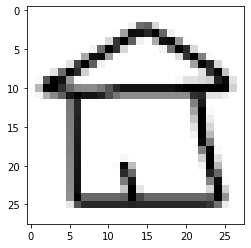

In [5]:
_= plt.imshow(data[14070,:,:,0], cmap='Greys')

## Discriminator 

In [6]:
def build_discriminator(depth=64, p=0.4):

    #define inputs - passed as 28X28 via img_w and img_h
    image = Input((img_w,img_h,1))

    #convolutional layers
    # number filetrs in first layer 64 and then doubled after each layer
    # filter size is 5 at each layer
    # dropout 40% at each layer
    conv1 = Conv2D(depth*1, 5, strides=2,
                    padding='same',activation='relu')(image)
    conv1 = Dropout(p)(conv1)

    conv2 = Conv2D(depth*2, 5, strides=2,
               padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)

    conv3 = Conv2D(depth*4, 5, strides=2,
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)

    conv4 = Conv2D(depth*8, 5, strides=1,
               padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    #Output layer
    prediction = Dense(1, activation='sigmoid')(conv4)

    #model defination
    model = Model(inputs=image, outputs=prediction)

    return model


In [7]:
# build discriminator
discriminator = build_discriminator()

In [8]:
# model(discriminator) summary
discriminator.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)        

In [9]:
# compile for CPU
from tensorflow.keras.optimizers import Adam 
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(lr=0.0008, 
                                     clipvalue=1.0), 
                      metrics=['accuracy'])

In [10]:
# compile for GPU
# discriminator.compile(loss='binary_crossentropy',
#                       optimizer=RMSprop(lr=0.0008,
#                                         decay=6e-8,
#                                         clipvalue=1.0), #clipvalue =1 to limit exploding gradients
#                       metrics=['accuracy'])

## Generator

In [11]:
z_dimensions = 32
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):

    #define inputs
    noise = Input((latent_dim, ))

    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # de-convolutional layers via Conv2DTranspose
    # Upsampling decreases the number of filters and increases the filer size
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2),
                            kernel_size=5, padding='same',
                            activation=None, )(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8),
                            kernel_size=5, padding='same',
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    #output layer
    image = Conv2D(1, kernel_size=5, padding='same',activation='sigmoid')(conv3)

    #model defination
    model = Model(inputs=noise, outputs=image)

    return model


In [12]:
# build generator
generator = build_generator()

In [13]:
# model(generator) summary
generator.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)       

## Adversarial Model Architecture

In [14]:
z = Input(shape=(z_dimensions,))
img = generator(z) # returns a 28x28 img
discriminator.trainable = False #freeze discriminator
pred = discriminator(img) # pass fake img to discriminator for prediction
adversarial_model = Model(z, pred) # construct the adversarial model 


In [15]:
# complie
adversarial_model.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(lr=0.0004,                                                                                          decay=3e-8,                                                                                         clipvalue=1.0),                          
                          metrics=['accuracy'])

In [16]:
adversarial_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
functional_3 (Functional)    (None, 28, 28, 1)         183713    
_________________________________________________________________
functional_1 (Functional)    (None, 1)                 4311553   
Total params: 4,495,266
Trainable params: 177,329
Non-trainable params: 4,317,937
_________________________________________________________________


## GAN Training

In [17]:
def train (epochs = 2000, batch = 128, z_dim=z_dimensions):

    # tracking metrics of the dicriminator and adversarial networks
    d_metrics = []
    a_metrics = []

    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in range(epochs):

        # sample real images
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))

        #generate fake images
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
            
        #concatenate images discriminator inputs
        x = np.concatenate((real_imgs,fake_imgs))

        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0


        #train discriminator
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        # adversarial net's noise input and "real" y:
        noise = np.random.uniform(-1.0, 1.0,
                                 size=[batch, z_dim])
        y = np.ones([batch,1])

        # train adversarial net:
        a_metrics.append(
          adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        # periodically print progress & fake images:
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0,
                                        size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0],
                            cmap='gray')
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    return a_metrics, d_metrics


Epoch #99
99: [D loss: 0.096007, acc: 0.965396] [A loss: 2.407458, acc: 0.453283]


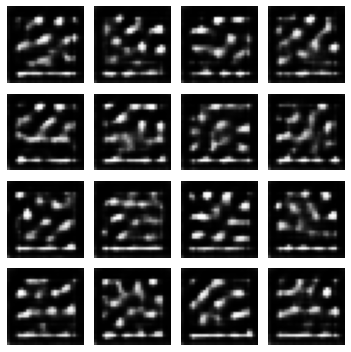

Epoch #199
199: [D loss: 0.081413, acc: 0.970752] [A loss: 4.578709, acc: 0.227191]


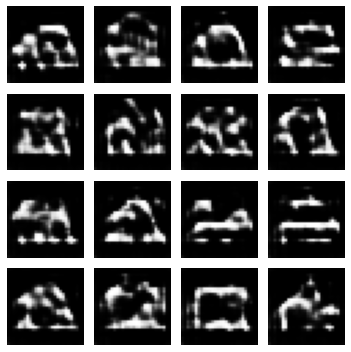

In [18]:
# train the GAN:
a_metrics_complete, d_metrics_complete = train()